# German License Plate Recognition

Training of a model for the recognition of German license plates in pictures taken by a smartphone camara.

### Importing Packages

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.1.0-rc2
GPU device: /device:GPU:0


### Training Parameter

In [2]:
from config import config

# datasets
TRAIN_HDF5 = config.TRAIN_HDF5
TEST_HDF5 = config.TEST_HDF5
BACKGRND_HDF5 = config.BACKGRND_HDF5

# image size <=> network input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

# training parameter
MAX_TEXT_LEN = config.MAX_TEXT_LEN

BATCH_SIZE = config.BATCH_SIZE
NUM_EPOCHS = config.NUM_EPOCHS

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = config.OPTIMIZER

OUTPUT_PATH = config.OUTPUT_PATH
DOCUMENTATION_PATH = config.DOCUMENTATION_PATH
MODEL_NAME = config.MODEL_NAME

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = config.TEST_IMAGES

# create model output directory
os.makedirs(os.path.join(config.OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("Train Dataset:      {}".format(TRAIN_HDF5))
print("Test Dataset:       {}".format(TEST_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs:             {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))

Train Dataset:      D:\development\tensorflow\ANPR\..\datasets\german_license_plates\train.h5
Test Dataset:       D:\development\tensorflow\ANPR\..\datasets\german_license_plates\test.h5
Background Dataset: D:\development\tensorflow\ANPR\..\datasets\german_license_plates\background.h5
Batch Size:         128
Epochs:             50
Image Size:         (128, 64)
Optimizer:          rmsprop
Model Name:         glpr-model
Output Path:        output
Documentation Path: documentation
Model Weights Path: output\rmsprop\glpr-model-weights.h5
Model Path:         output\rmsprop\glpr-model.h5


### Data Loading

In [3]:
from pyimagesearch.io import Hdf5DatasetLoader
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
X_train, y_train = loader.load(TRAIN_HDF5, shuffle=True)
X_test, y_test = loader.load(TEST_HDF5, shuffle=True)

print("Train dataset size: {}".format(X_train.shape[0]))
print("Test dataset size:  {}".format(X_test.shape[0]))

#images, labels = loader.load(TRAIN_HDF5, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Train dataset size: 65276
Test dataset size:  16319


C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


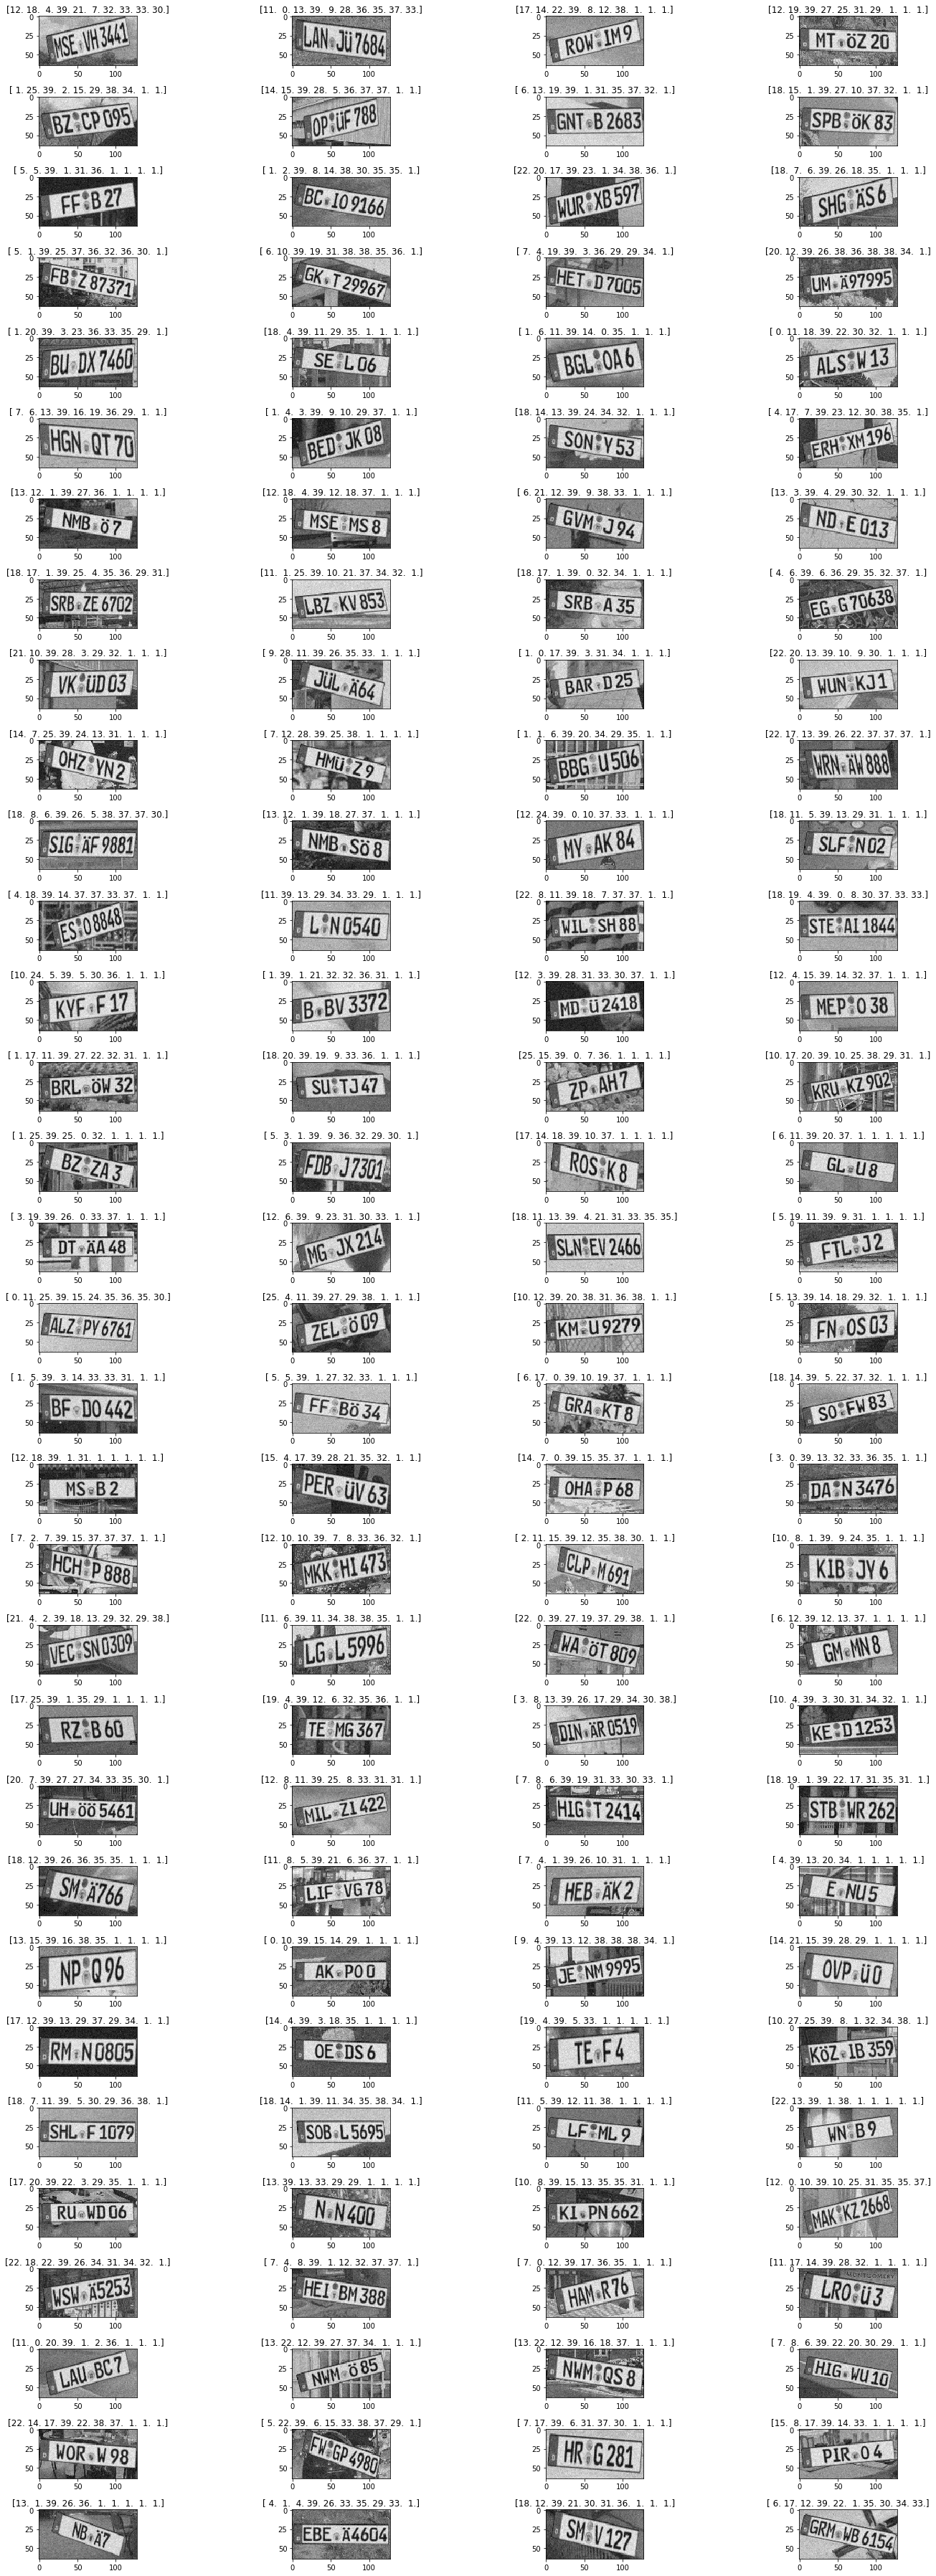

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentator import LicensePlateImageAugmentator
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from label_codec import LabelCodec
import skimage

loader = Hdf5DatasetLoader()
background_images = loader.load(BACKGRND_HDF5, shuffle=True, max_items=10000)
    
augmentator = LicensePlateImageAugmentator(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT, 
                                               MAX_TEXT_LEN, BATCH_SIZE, augmentator)

val_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             MAX_TEXT_LEN, BATCH_SIZE, augmentator)

inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create and train the CRNN

In [5]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from pyimagesearch.nn.conv import OCR
from label_codec import LabelCodec

def get_optimizer(optimizer):
    if optimizer == "sdg":
        return SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer == "rmsprop":
        return RMSprop(learning_rate=0.001)
    if optimizer == "adam":
        return Adam(learning_rate=0.001)
    if optimizer == "adagrad":
        return Adagrad(learning_rate=0.001)
    if optimizer == "adadelta":
        return Adadelta(learning_rate=0.1)
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
        predictions = predictions[:, 2:, :]
        loss = tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)
        loss = tf.reduce_mean(loss)
        return loss

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((IMAGE_WIDTH, IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 16)        2320      
____________________________________________

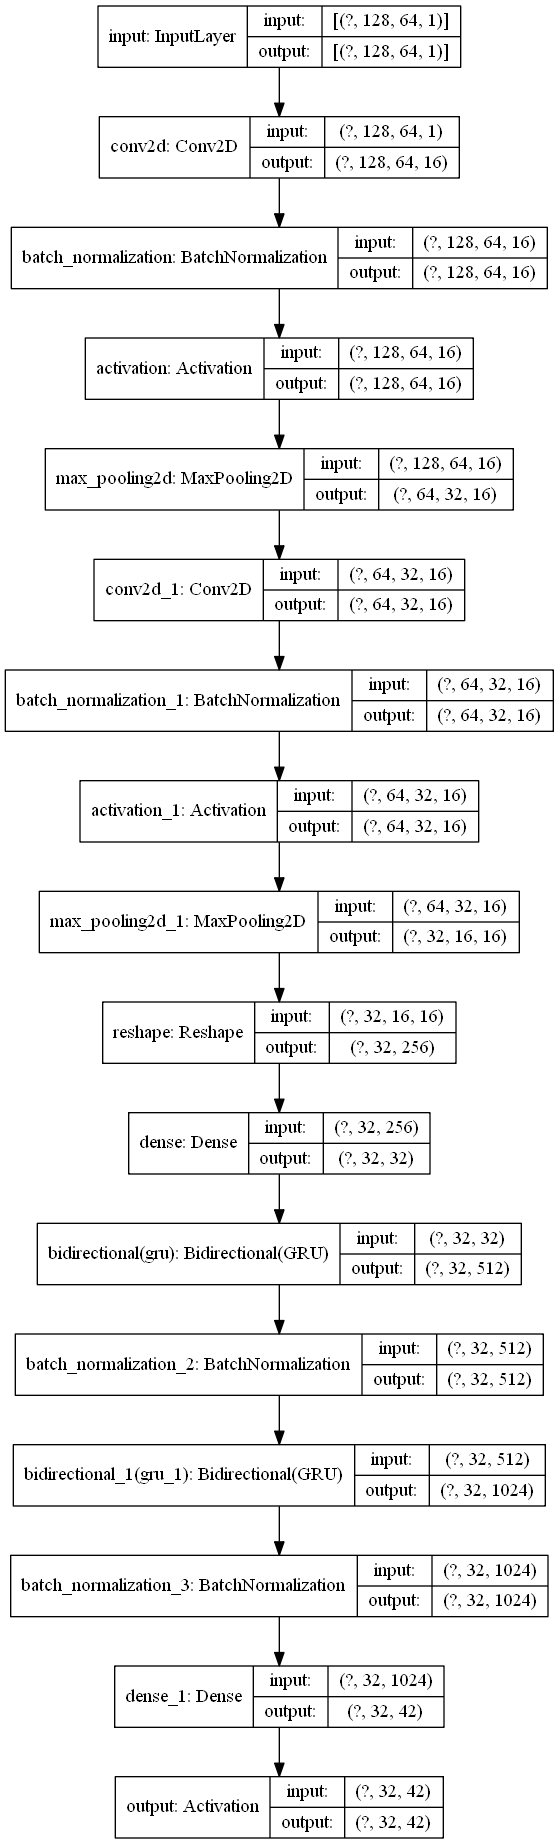

In [6]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint

def get_callbacks(weights_path, optimizer):    
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1),
        ModelCheckpoint(filepath=MODEL_WEIGHTS_PATH, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01, cooldown=0, min_lr=0),
        TensorBoard(log_dir=os.path.join("logs", optimizer))]
    return callbacks

#### Train the network

In [ ]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(MODEL_WEIGHTS_PATH, OPTIMIZER), verbose=1)

Epoch 1/50
  5/509 [..............................] - ETA: 18:19 - loss: 67.8579

#### Create and save prediction model

In [ ]:
from tensorflow.keras.models import save_model

predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-" + OPTIMIZER + "-train-history.png")
plt.show()

In [ ]:
predict_model.save('out', save_format='tf')

In [ ]:
tf.saved_model.save(predict_model, "saved_model")